In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
import statsmodels.api as sm
import seaborn as sns
from collections import defaultdict

In [3]:
data_folder = Path('../../../data')
supp_figure_folder = Path('../../../SupplementalFigures')
figure_folder = Path('../../../Figures')
organism = 'e_coli'
exometabolites_folder = data_folder / 'paczia_2012' /f"{organism}"
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_auc = data_folder / 'paczia_2012' /f"{organism}"/ 'auc_ecoli.csv'
concentrations_fn = data_folder / 'paczia_2012' /f"{organism}"/'conc_ecoli.csv'

In [4]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv = {value:key for key, value in met_abrv_to_name.items()}


In [5]:
df_auc = pd.read_csv(fn_auc, index_col=0)
conc_df = pd.read_csv(concentrations_fn, index_col=0)
concentrations_std = pd.read_csv(data_folder / 'paczia_2012' /f"{organism}"/'conc_std_ecoli.csv')

In [6]:
auc_end_exp_phase = df_auc.loc[10, 'AUC']

In [7]:
specific_limits = {
    'G6P': (1, 10),
    'F6P': (1, 10),
    'FBP': (7, 10),
    'DHAP': (1, 10),
    'GA3P': (1, 10),
    '23PG': (1, 10),
    'PEP': (3, 10),
    'R5P': (1, 10),
    'RU5P+X5P': (3, 10),
    'E4P': (6, 10),
    'CIT': (1, 10),
    'ACN': (1, 10),
    'ICIT': (1, 10),
    'OAS': (1, 7),
    'GLU': (1, 10),
    'SER': (1, 10),
    'ASP': (1, 10),
    'THR': (1, 10),
    'HOM': (1, 10),
    'TYR': (1, 10),
    'GLY': (1, 10),
    'PRO': (1, 8),
    'ALA': (1, 9),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 10),
    'ILEU': (1, 10),
    'LEU': (1, 10),
    'TRP': (1, 6),
    'HIS': (1, 6),
    'ARG': (1, 7),
    'PYR': (1, 8),
    'ORO': (1, 8),
    'FUM': (3, 8),
    'URA': (1, 10),
    'AKG': (7, 10),
    'ACT': (1, 8)
}

In [8]:
metabolite_names = sorted([met_abrv_to_name[c] for c in conc_df.columns])


In [9]:
max_conc = []
for i,metabolite in enumerate(metabolite_names):
    c = met_name_to_abrv[metabolite]
    conc = conc_df[c][:-1]*1e-3 # Convert from uM to mM #
    # conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    conc[conc==0] = np.nan
    idx = ((conc_df.index >= lim[0]) & (conc_df.index <= lim[1]))[:-1] & np.isfinite(conc)
    rate_conc = conc[idx]
    if rate_conc.size > 0:
        max_conc.append([metabolite, c, rate_conc.max()])
max_conc_df = pd.DataFrame(max_conc, columns=['Metabolite', 'Metabolite id', 'Max Concentration (mM)'])
max_conc_df.sort_values(by='Max Concentration (mM)', ascending=False, inplace=True) 

In [91]:
plot_levels = {
    1:['ACT', 'PYR', 'ORO', ],
    2:['URA', 'CIT', 'AKG', 'DHAP'],
    3:['FBP', 'F6P', 'ICIT', 'G6P'],
    4:[ 'ACN', '23PG', 'GLU', 'ARG'],
    5:['GA3P', 'HIS', 'R5P','FUM'],
    6:['PEP', 'RU5P+X5P', 'HOM', 'THR'],
    7:[ 'ALA', 'OAS', 'ILEU'],
    8:['LEU', 'ASP', 'VAL', 'E4P'],
    9:['GLY', 'TYR', 'SER', 'PHE'],
    10:['MET','PRO', 'TRP']
}

In [ ]:
def get_angle(x_fit, y_fit):
    x0, x1 = x_fit[0], x_fit[-1]
    y0, y1 = y_fit[0], y_fit[-1]
    trans = ax.transData.transform
    (x_disp0, y_disp0), (x_disp1, y_disp1) = trans((x0, y0)), trans((x1, y1))
    angle_disp = np.degrees(np.arctan2(y_disp1 - y_disp0, x_disp1 - x_disp0))
    return angle_disp

Level 1: ACT, PYR, ORO
Level 2: URA, CIT, AKG, DHAP
Level 3: FBP, F6P, ICIT, G6P
Level 4: ACN, 23PG, GLU, ARG
GLU
Level 5: GA3P, HIS, R5P, FUM
Level 6: PEP, RU5P+X5P, HOM, THR
Level 7: ALA, OAS, ILEU
Level 8: LEU, ASP, VAL, E4P
Level 9: GLY, TYR, SER, PHE
GLY
Level 10: MET, PRO, TRP


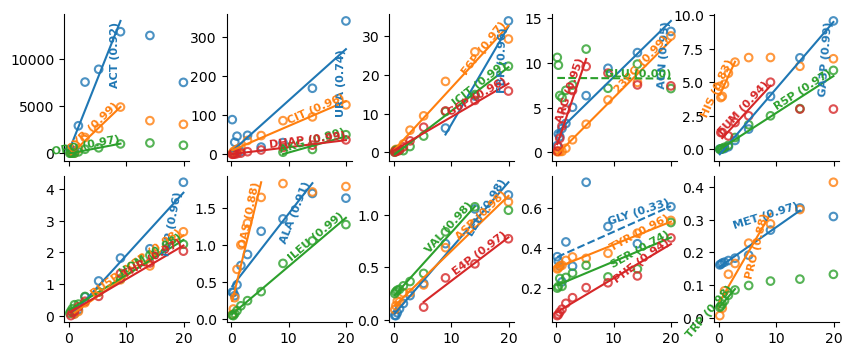

In [109]:
fig, axes = plt.subplots(2,5, figsize=(10, 4), sharex=True)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b


for level, metabolites in plot_levels.items():
    print(f"Level {level}: {', '.join(metabolites)}")
    ax = axes[level-1]
    ymax = 0
    for i, c in enumerate(metabolites):
        # c = met_name_to_abrv[metabolite]
        conc = conc_df[c][:-1] # uM
        # conc_std = concentrations_std[c][:-1]
        lim = specific_limits[c]
        conc[conc==0] = np.nan
        idx = ((conc_df.index >= lim[0]) & (conc_df.index <= lim[1]))[:-1] & np.isfinite(conc)
        rate_conc = conc[idx]
        ax_idx = df_auc['AUC'] <= auc_end_exp_phase
        ax_conc = conc[ax_idx]
        ymax = max(ymax, ax_conc.max())

    
        if rate_conc.size > 0:

            # ax.errorbar(x = df_auc.loc[ax_idx, 'AUC'], y = ax_conc, yerr = conc_std, 
            #          fmt='o',color=f'C{i}',capthick=0,elinewidth=0,capsize=0,
            #          zorder = 0, label = c, markeredgecolor = f'C{i}', markerfacecolor = 'none', markeredgewidth=1.5)#alpha = 0.8
            ax.scatter(df_auc.loc[ax_idx, 'AUC'], ax_conc, label=c, s=30, alpha=0.8,marker='o', edgecolor=f'C{i}', 
                       facecolor='none', linewidth=1.5)
            # ax.legend(loc='upper left', fontsize='x-small', 
            #           bbox_to_anchor=(0, 1), borderaxespad=0.4, ncols = 2)
            
            res = scipy.stats.linregress(df_auc.loc[idx, 'AUC'], rate_conc)
            x_fit = np.linspace(df_auc.loc[idx, 'AUC'].min(), df_auc.loc[idx, 'AUC'].max(), 3, endpoint=True)
            y_fit = fun(x_fit, res.slope, res.intercept)
            if res.rvalue**2 > 0.7:
                ax.plot(x_fit, y_fit, color=f'C{i}', linestyle='-', linewidth=1.5)
            else:
                ax.plot(x_fit, y_fit, color=f'C{i}', linestyle='--', linewidth=1.5)
                print(c)
            angle = get_angle(x_fit, y_fit)
            ax.text(
                x_fit[-1], y_fit[-1],
                f"{c} ({res.rvalue**2:.2f})",
                color=f'C{i}', fontsize=8, va='bottom', ha='right', fontweight='bold',
                rotation=angle, rotation_mode='anchor'
            )
            
        # ax.set_xlim(0, auc_end_exp_phase*1.05)
        # ax.set_ylim(0, ymax*1.05)
        plt.subplots_adjust(hspace=0.1, wspace=0.3)
        sns.despine()
        plt.savefig(figure_folder / f"figure_1B_rate_estimate_level.pdf", bbox_inches='tight')

In [191]:
met_abrv_to_short_name = met_abrv_to_name.copy()
met_abrv_to_short_name.update({
    'AKG': r'$\alpha$-KG',
    'RU5P+X5P': 'RU5P/X5P',
    'DHAP': 'DHAP',
    'GA3P': 'GA3P',
    '23PG': '2/3PG',
    'G6P': 'G6P',
    'PEP': 'PEP',
    'E4P': 'E4P',
    'R5P': 'R5P',
    'F6P': 'F6P',
    'FBP': 'FBP'})


AKG
FBP
GLU
GLY


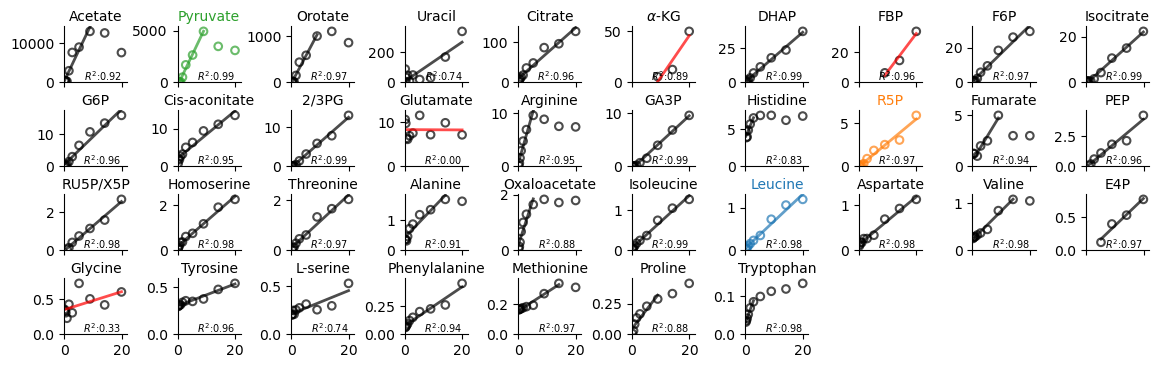

In [192]:
plot_order = sum(plot_levels.values(), [])
fig, axes = plt.subplots(4,10, figsize=(14, 4), sharex=True)
axes = axes.flatten()
abrv_to_color = defaultdict(lambda: 'k')
abrv_to_color['LEU'] = 'C0'
abrv_to_color['R5P'] = 'C1'
abrv_to_color['PYR'] = 'C2'


for i, c in enumerate(plot_order):
    ax = axes[i]
    conc = conc_df[c][:-1] # uM
    lim = specific_limits[c]
    conc[conc==0] = np.nan
    idx = ((conc_df.index >= lim[0]) & (conc_df.index <= lim[1]))[:-1] & np.isfinite(conc)
    rate_conc = conc[idx]
    ax_idx = df_auc['AUC'] <= auc_end_exp_phase
    ax_conc = conc[ax_idx]
    ax.set_title(met_abrv_to_short_name[c], fontsize=10, fontweight='normal', y = 0.95, color = abrv_to_color[c])
    ax.scatter(df_auc.loc[ax_idx, 'AUC'], ax_conc, label=c, s=30, alpha=0.7,marker='o', edgecolor=abrv_to_color[c],#f'C{i}', 
                       facecolor='none', linewidth=1.5)
            # ax.legend(loc='upper left', fontsize='x-small', 
            #           bbox_to_anchor=(0, 1), borderaxespad=0.4, ncols = 2)
            
    res = scipy.stats.linregress(df_auc.loc[idx, 'AUC'], rate_conc)
    x_fit = np.linspace(df_auc.loc[idx, 'AUC'].min(), df_auc.loc[idx, 'AUC'].max(), 3, endpoint=True)
    y_fit = fun(x_fit, res.slope, res.intercept)
    ymax = ax_conc.max()
    ax.set_ylim(0, ymax*1.1)
    ax.set_xlim(0, auc_end_exp_phase*1.1)

    if (res.rvalue**2 > 0.5) and (res.pvalue < 0.05):
        ax.plot(x_fit, y_fit, color=abrv_to_color[c], linestyle='-', linewidth=2, alpha = 0.7)#f'C{i}'
    else:
        ax.plot(x_fit, y_fit, color='r', linestyle='-', linewidth=2, alpha = 0.7)#f'C{i}'
        print(c)
    ax.text(20, 0, 
        f"$R^2$:{res.rvalue**2:.2f}",
        color='k', fontsize=7, va='bottom', ha='right',
    )
plt.subplots_adjust(hspace=0.5, wspace=0.8)

sns.despine()
i+=1
while i < 40:  # Fill remaining axes with empty plots
    ax = axes[i]
    ax.axis('off')
    i += 1
plt.savefig(figure_folder / f"figure_1B_rate_estimate_all.pdf", bbox_inches='tight')

In [187]:
met_abrv_to_name['E4P'] 



'Erythrose-4-phosphate'

In [101]:
np.degrees(np.arctan(res.slope/ymax))
print(res.slope)

0.020551611414227157
